In [256]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


df = pd.read_csv('daily_demand.csv', parse_dates = ['fecha'])
df['dia_festivo'].astype('category')
df['dia_semana'].astype('category')
df.drop(['monto_total','semana_ano', 'mes', 'trimestre', 'ano','semana_inicio'], axis=1, inplace=True)
horizon = 30
test_df = df.groupby('platillo_id').tail(horizon)
train_df = df.drop(test_df.index)
train_df.shape, test_df.shape

stats = []
for pid, g in train_df.groupby('platillo_id'):
    s = g.sort_values('fecha')['cantidad']
    stats.append({
        'platillo_id':    pid,
        'mean_sales':     s.mean(),
        'std_sales':      s.std(),
        'var_sales':      s.var(),
        'cv_sales':       s.std()/s.mean() if s.mean() else 0,
        'spike_count':    (s > s.mean() + 2*s.std()).sum(),
        'zero_days_ratio':(s == 0).mean(),
    })
stats_df = pd.DataFrame(stats)

# 5) Fit scaler y PCA en train → embeddings
num_cols = ['mean_sales','std_sales','var_sales','cv_sales','spike_count','zero_days_ratio']
scaler = StandardScaler().fit(stats_df[num_cols].fillna(0))
X_train_stats = scaler.transform(stats_df[num_cols].fillna(0))

pca_dummy = PCA().fit(X_train_stats)
cum_var = np.cumsum(pca_dummy.explained_variance_ratio_)
k = np.searchsorted(cum_var, 0.95) + 1
pca = PCA(n_components=k, random_state=42).fit(X_train_stats)
emb_train = pca.transform(X_train_stats)

emb_df_train = pd.DataFrame(
    emb_train,
    columns=[f'pca_emb_{i}' for i in range(k)]
)
emb_df_train['platillo_id'] = stats_df['platillo_id']

train_df = train_df.merge(emb_df_train, on='platillo_id')
test_df = test_df.merge(emb_df_train, on='platillo_id')

feature_cols = ['lag_1','lag_7','ocupacion','dia_semana','dia_festivo'] + [f'pca_emb_{i}' for i in range(k)]

In [260]:
stats_df

,platillo_id,mean_sales,std_sales,var_sales,cv_sales,spike_count,zero_days_ratio
0,121,28.901370,21.877057,478.605630,0.756956,20,0.000000
1,124,10.898630,6.978233,48.695740,0.640285,16,0.008219
2,125,3.794521,3.816386,14.564805,1.005762,16,0.221918
3,126,20.109589,14.757715,217.790155,0.733865,22,0.002740
4,134,9.194521,8.344767,69.635135,0.907580,18,0.084932
...,...,...,...,...,...,...,...
88,704,1.780822,3.987779,15.902378,2.239291,19,0.602740
89,705,1.320548,2.115806,4.476637,1.602219,13,0.526027
90,706,4.687671,12.990740,168.759326,2.771257,21,0.616438
91,714,1.986301,5.058159,25.584977,2.546522,17,0.613699


In [257]:
params = {'objective':'tweedie','metric':'rmse','verbosity':-1, "bagging_fraction": 0.8,
  "feature_fraction": 0.8,
  "lambda_l1": 1.0,
  "lambda_l2": 0,
  "learning_rate": 0.05,
  "max_depth": -1,
  "num_leaves": 31,
  }

# 7) Definir matrices de features y target
X_train = train_df[feature_cols]
y_train = train_df['cantidad']
X_test  = test_df[feature_cols]
y_test  = test_df['cantidad']

model = LGBMRegressor(**params)
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    eval_metric='rmse'
)

LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=1.0,
              lambda_l2=0, learning_rate=0.05, metric='rmse',
              objective='tweedie', verbosity=-1)

In [258]:
y_pred_train = model.predict(X_train)

mae_train  = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"Train MAE : {mae_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")

Train MAE : 3.8199
Train RMSE: 6.6669


In [259]:
# 9) Predicción sobre test
preds = model.predict(X_test)
# 10) Evaluación de métricas
mae  = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"MAE en últimos {horizon} días: {mae:.2f}")
print(f"RMSE en últimos {horizon} días: {rmse:.2f}")

MAE en últimos 30 días: 3.87
RMSE en últimos 30 días: 7.65


In [251]:
test_df['preds'] = preds

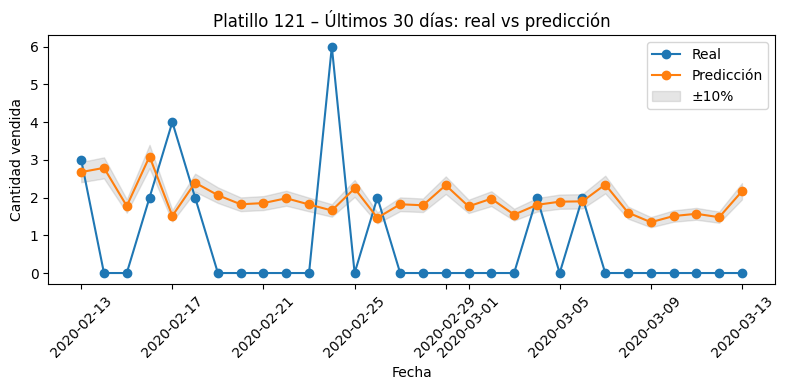

In [263]:
# 11) Gráfica para platillo 121
df121 = test_df[test_df['platillo_id'] == 310].copy()
df121['preds'] = preds[df121.index]

plt.figure(figsize=(8, 4))
plt.plot(df121['fecha'], df121['cantidad'], marker='o', label='Real')
plt.plot(df121['fecha'], df121['preds'],    marker='o', label='Predicción')
plt.fill_between(
    df121['fecha'],
    df121['preds'] * 0.9,
    df121['preds'] * 1.1,
    color='gray', alpha=0.2, label='±10%'
)
plt.title('Platillo 121 – Últimos 30 días: real vs predicción')
plt.xlabel('Fecha')
plt.ylabel('Cantidad vendida')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [184]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error

# 1) Prepara tus datos ya con embeddings y lags:
#    X = train_df[feature_cols]
#    y = train_df['cantidad']

# 2) Define el modelo base
model = LGBMRegressor(objective='regression', verbosity=-1)

# 3) Define la malla de parámetros
param_grid = {
    'learning_rate'    : [0.01, 0.05, 0.1],
    'num_leaves'       : [31, 63, 127],
    'max_depth'        : [5, 10, -1],
    'feature_fraction' : [0.6, 0.8, 1.0],
    'bagging_fraction' : [0.6, 0.8, 1.0],
    'lambda_l1'        : [0, 0.1, 1.0],
    'lambda_l2'        : [0, 0.1, 1.0],
}

# 4) Prepara la métrica (RMSE positivo)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                          greater_is_better=False)

# 5) Crea el GridSearch
gs = GridSearchCV(
    estimator     = model,
    param_grid    = param_grid,
    scoring       = rmse_scorer,
    cv            = 3,
    n_jobs        = -1,
    verbose       = 1,
    return_train_score = True
)

X = train_df[feature_cols]
y = train_df['cantidad']

# 6) Ejecuta la búsqueda
gs.fit(X, y)

# 7) Extrae los 5 mejores
results_df = pd.DataFrame(gs.cv_results_)
# 'mean_test_score' está en negativo RMSE, así que buscamos los valores más altos (menos negativos)
top5 = results_df.sort_values('mean_test_score', ascending=False).head(5)

# 8) Muestra los parámetros y el RMSE correspondiente
print(top5[['params', 'mean_test_score', 'std_test_score']])


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
                                                 params  mean_test_score  \
1149  {'bagging_fraction': 0.8, 'feature_fraction': ...        -7.515016   
1878  {'bagging_fraction': 1.0, 'feature_fraction': ...        -7.515016   
420   {'bagging_fraction': 0.6, 'feature_fraction': ...        -7.515016   
339   {'bagging_fraction': 0.6, 'feature_fraction': ...        -7.521732   
1068  {'bagging_fraction': 0.8, 'feature_fraction': ...        -7.521732   

      std_test_score  
1149        1.580750  
1878        1.580750  
420         1.580750  
339         1.577439  
1068        1.577439  


In [191]:
for idx in range(len(top5)):
    row = top5.iloc[idx]
    print(f"\nModelo {idx+1}:")
    for p_name, p_val in row['params'].items():
        print(f"  {p_name}: {p_val}")


Modelo 1:
  bagging_fraction: 0.8
  feature_fraction: 0.8
  lambda_l1: 1.0
  lambda_l2: 0
  learning_rate: 0.05
  max_depth: -1
  num_leaves: 31

Modelo 2:
  bagging_fraction: 1.0
  feature_fraction: 0.8
  lambda_l1: 1.0
  lambda_l2: 0
  learning_rate: 0.05
  max_depth: -1
  num_leaves: 31

Modelo 3:
  bagging_fraction: 0.6
  feature_fraction: 0.8
  lambda_l1: 1.0
  lambda_l2: 0
  learning_rate: 0.05
  max_depth: -1
  num_leaves: 31

Modelo 4:
  bagging_fraction: 0.6
  feature_fraction: 0.8
  lambda_l1: 0.1
  lambda_l2: 0
  learning_rate: 0.05
  max_depth: -1
  num_leaves: 31

Modelo 5:
  bagging_fraction: 0.8
  feature_fraction: 0.8
  lambda_l1: 0.1
  lambda_l2: 0
  learning_rate: 0.05
  max_depth: -1
  num_leaves: 31
